# Fitbit Identifier

- Steven Garis & Matthew Capper

## Imports

In [1]:
# data manipulation 
import numpy as np
import pandas as pd

from datetime import datetime, timedelta
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

from fbprophet import Prophet

import statsmodels.api as sm
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Functions

In [2]:
# Used to get more datetime fields to work with.
def expand_dt(df):
    df['time'] = df.index
    df['year'] = df.time.dt.year
    df['quarter'] = df.time.dt.quarter
    df['month'] = df.time.dt.month
    df['day_of_month'] = df.time.dt.day
    df['day_of_week'] = df.time.dt.day_name().str[:3]
    df['is_weekend'] = ((pd.DatetimeIndex(df.index).dayofweek) > 4)
    df.drop(columns=['time'], inplace=True)
    return df



## Data Acquisition

- CSVs were provided with the thumb drive

In [3]:
# Making each csv a DataFrame that is split on new line

a = '2018-04-26_through_2018-05-26.csv'
b = '2018-05-27_through_2018-06-26.csv'
c = '2018-06-27_through_2018-07-27.csv'
d = '2018-07-28_through_2018-08-26.csv'
e = '2018-08-27_through_2018-09-26.csv'
g = '2018-09-27_through_2018-10-27.csv'
h = '2018-10-28_through-2018-11-27.csv'
i = '2018-11-28_through_2018-12-28.csv'

FILE = a
with open(FILE) as f:
    contents = f.read()
a = contents.split('\n')
a = pd.DataFrame(a)

FILE = b
with open(FILE) as f:
    contents = f.read()
b = contents.split('\n')
b = pd.DataFrame(b)

FILE = c
with open(FILE) as f:
    contents = f.read()
c = contents.split('\n')
c = pd.DataFrame(c)

FILE = d
with open(FILE) as f:
    contents = f.read()
d = contents.split('\n')
d = pd.DataFrame(d)

FILE = e
with open(FILE) as f:
    contents = f.read()
e = contents.split('\n')
e = pd.DataFrame(e)

FILE = g
with open(FILE) as f:
    contents = f.read()
g = contents.split('\n')
g = pd.DataFrame(g)

FILE = h
with open(FILE) as f:
    contents = f.read()
h = contents.split('\n')
h = pd.DataFrame(h)

FILE = i
with open(FILE) as f:
    contents = f.read()
i = contents.split('\n')
i = pd.DataFrame(i)


## Data Preparation

In [4]:
# Grabbing just the Activities section. All the other sections were filled with a 0.
a = a.iloc[35:67]
b = b.iloc[36:67]
c = c.iloc[36:67]
d = d.iloc[35:65]
e = e.iloc[36:67]
g = g.iloc[36:67]
h = h.iloc[36:67]
i = i.iloc[36:45]

# Combining them in order of the date 
df = a.append(b).append(c).append(d).append(e).append(g).append(h).append(i)
df = df.reset_index()


In [5]:
# Splitting into columns 
df = df[0].str.split('","', expand=True)

# Renaming the colums
df.rename(columns={0: 'date', 
                   1: 'calories_burned', 
                   2: 'steps', 
                   3: 'distance',
                   4: 'floors',
                   5: 'minutes_sedentary',
                   6: 'minutes_lightly_active',
                   7: 'minutes_fairly_active',
                   8: 'minutes_very_active',
                   9: 'activity_calories'}, inplace=True)

# Dropping the old columns names that could't split.
df.drop(index=0, inplace=True)

# Removing the '"' that got left over
df['activity_calories'] = df.activity_calories.str.replace('"','')
df['date'] = df.date.str.replace('"','')

# Removing ',' from numbers
for col in df:
    df[col] = df[col].str.replace(',','')

# Setting date to datetime and setting as index
df['date'] = pd.to_datetime(df.date)
df.set_index('date', inplace=True)


# Getting a list of columns
columns = df.columns

# Converting from object to numeric
df[columns] = df[columns].apply(pd.to_numeric, errors='coerce')

# Expanding DT 
df = expand_dt(df)




#### Checking the prep:

- We have all the dates from the min to max but...
- We are missing dates from 2018-12-07 to 2018-12-28
- There are no missing values

In [6]:
print('Total days: ', df.index.nunique())
print('Start date: ',df.index.min())
print('End date  : ',df.index.max())

Total days:  225
Start date:  2018-04-26 00:00:00
End date  :  2018-12-06 00:00:00


In [7]:
# Checking to see if there are missing dates from min to max

timedelta(df.index.nunique()) == (df.index.max() - df.index.min()) + timedelta(days=1)


True

In [8]:
df.dtypes

calories_burned             int64
steps                       int64
distance                  float64
floors                      int64
minutes_sedentary           int64
minutes_lightly_active      int64
minutes_fairly_active       int64
minutes_very_active         int64
activity_calories           int64
year                        int64
quarter                     int64
month                       int64
day_of_month                int64
day_of_week                object
is_weekend                   bool
dtype: object

In [9]:
df.isnull().sum()

calories_burned           0
steps                     0
distance                  0
floors                    0
minutes_sedentary         0
minutes_lightly_active    0
minutes_fairly_active     0
minutes_very_active       0
activity_calories         0
year                      0
quarter                   0
month                     0
day_of_month              0
day_of_week               0
is_weekend                0
dtype: int64

## Data Exploration

In [10]:
df.index.max() - timedelta(weeks=4)

Timestamp('2018-11-08 00:00:00', freq='D')

In [11]:
train = df[:'2018-11-08']
test = df['2018-11-08':]



# aggregation = 'mean'
# train = df[:'2018-11-08'].resample('M').agg(aggregation)
# test = df['2018-11-08':].resample('M').agg(aggregation)



In [12]:
train.describe()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,year,quarter,month,day_of_month
count,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.0,197.000000,197.000000,197.000000
mean,3352.994924,7859.944162,3.711574,9.994924,835.096447,180.629442,14.401015,30.040609,1402.350254,2018.0,2.862944,7.553299,15.685279
std,638.501302,5065.369218,2.395296,19.361359,246.743248,75.324128,15.368487,35.503785,738.788103,0.0,0.718912,1.885349,9.102726
min,799.000000,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,2018.0,2.000000,4.000000,1.000000
25%,3043.000000,4446.000000,2.100000,2.000000,674.000000,152.000000,2.000000,0.000000,999.000000,2018.0,2.000000,6.000000,8.000000
50%,3348.000000,7034.000000,3.320000,6.000000,773.000000,196.000000,10.000000,13.000000,1388.000000,2018.0,3.000000,8.000000,16.000000
75%,3719.000000,11061.000000,5.220000,11.000000,907.000000,232.000000,20.000000,56.000000,1817.000000,2018.0,3.000000,9.000000,24.000000
max,5199.000000,21302.000000,10.050000,162.000000,1440.000000,349.000000,78.000000,125.000000,3596.000000,2018.0,4.000000,11.000000,31.000000


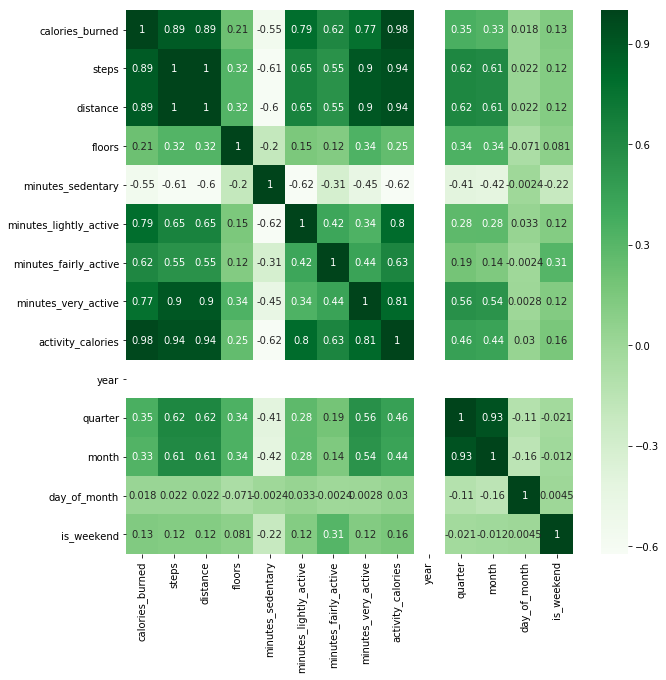

In [13]:
plt.figure(figsize=(10,10))
sns.heatmap(data=train.corr(), annot=True, cmap='Greens')

In [14]:
df.groupby('day_of_week')[['calories_burned','steps','distance','floors']].mean()

,calories_burned,steps,distance,floors
day_of_week,,,,
Fri,3464.718750,8847.250000,4.180625,11.062500
Mon,3242.750000,7245.406250,3.439688,6.718750
Sat,3553.187500,9549.656250,4.591563,13.562500
Sun,3551.468750,9904.500000,4.669062,21.843750
Thu,3425.939394,8748.636364,4.157576,12.545455
Tue,3304.093750,7856.875000,3.702813,11.250000
Wed,3270.468750,7594.343750,3.582812,11.156250


In [15]:
# Looks like they are mostly active on the weekends

df.groupby('is_weekend')[['calories_burned','steps','distance','floors']].mean()

,calories_burned,steps,distance,floors
is_weekend,,,,
False,3342.118012,8062.788820,3.814845,10.559006
True,3552.328125,9727.078125,4.630312,17.703125


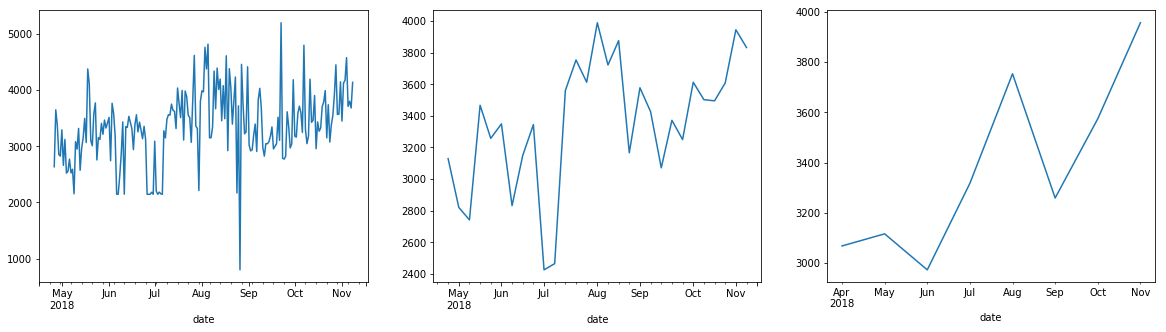

In [16]:
# sns.tsplot or sns.lineplot

plt.figure(figsize=(20,5))

plt.subplot(131)
train.resample('D').calories_burned.mean().plot()

plt.subplot(132)
train.resample('W').calories_burned.mean().plot()

plt.subplot(133)
train.resample('M').calories_burned.mean().plot()


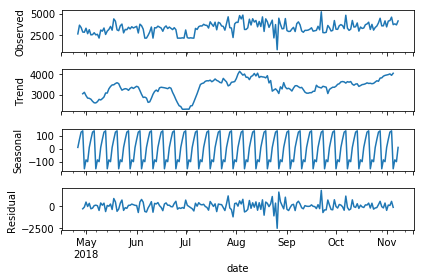

In [17]:
cal_burn = train.resample('D').calories_burned.mean()

decomposition = sm.tsa.seasonal_decompose(cal_burn, model='additive')
fig = decomposition.plot()


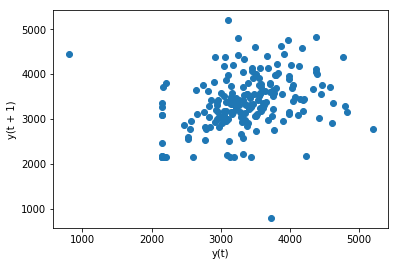

In [18]:
pd.plotting.lag_plot(cal_burn)

In [19]:
df_corr = pd.concat([cal_burn.shift(1), cal_burn], axis=1)
df_corr.columns = ['t-1','t+1']
result = df_corr.corr()
print(result)


          t-1       t+1
t-1  1.000000  0.327216
t+1  0.327216  1.000000


In [20]:
df.describe()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,year,quarter,month,day_of_month
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.0,225.000000,225.000000,225.000000
mean,3401.911111,8536.186667,4.046800,12.591111,809.520000,188.235556,14.920000,33.871111,1484.546667,2018.0,3.004444,8.008889,15.733333
std,632.426578,5255.746608,2.506253,25.844174,243.232639,75.170001,15.363535,37.195986,747.795790,0.0,0.770539,2.144326,9.051933
min,799.000000,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,2018.0,2.000000,4.000000,1.000000
25%,3069.000000,4714.000000,2.220000,2.000000,654.000000,158.000000,3.000000,2.000000,1062.000000,2018.0,2.000000,6.000000,8.000000
50%,3385.000000,7806.000000,3.680000,7.000000,750.000000,203.000000,11.000000,15.000000,1481.000000,2018.0,3.000000,8.000000,16.000000
75%,3765.000000,12380.000000,5.900000,13.000000,877.000000,236.000000,21.000000,63.000000,1962.000000,2018.0,4.000000,10.000000,24.000000
max,5199.000000,25512.000000,12.000000,195.000000,1440.000000,349.000000,78.000000,154.000000,3596.000000,2018.0,4.000000,12.000000,31.000000


In [21]:
df.head()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,year,quarter,month,day_of_month,day_of_week,is_weekend
date,,,,,,,,,,,,,,,
2018-04-26,2635,2931,1.38,2,1347,93,0,0,566,2018,2,4,26,Thu,False
2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752,2018,2,4,27,Fri,False
2018-04-28,3379,3521,1.66,2,702,155,22,11,1124,2018,2,4,28,Sat,True
2018-04-29,2851,1639,0.77,0,891,122,0,0,602,2018,2,4,29,Sun,True
2018-04-30,2825,1323,0.62,0,880,104,0,0,540,2018,2,4,30,Mon,False


## Modeling

In [22]:
def embed_data(x, steps):
    n = len(x)
    xout = np.zeros((n-steps, steps))
    yout = x[steps:]
    for i in np.arange(steps, n):
        xout[i-steps] = x[i-steps:i]
    return xout, yout

df = df[['calories_burned','steps','distance','floors','minutes_sedentary','minutes_lightly_active','minutes_fairly_active','minutes_very_active','activity_calories']]

aggregation = 'mean'

for col in df:
    train = df[:'2018-11-08'][col].resample('D').agg(aggregation)
    test = df['2018-11-08':][col].resample('D').agg(aggregation)

    xtrain,ytrain = embed_data(train, 3)
    xtest,ytest = embed_data(test, 3)

    m = svm.SVR(kernel='rbf', C=1, gamma=0.1)
    m_fit = m.fit(xtrain, ytrain)

    y_pred = m_fit.predict(xtrain)
    mse = metrics.mean_squared_error(y_pred, ytrain)
    rmse = math.sqrt(mse)
    print(col, 'Train RMSR: ', rmse)

    y_pred = m_fit.predict(xtest)
    mse = metrics.mean_squared_error(y_pred, ytest)
    rmse = math.sqrt(mse)
    print(col, 'Test RMSR: ', rmse)

    print('--'*10)


calories_burned Train RMSR:  638.6622343522415
calories_burned Test RMSR:  585.2146877593135
--------------------
steps Train RMSR:  5138.44267620044
steps Test RMSR:  7319.182337949633
--------------------
distance Train RMSR:  1.6501220131271959
distance Test RMSR:  2.2249518764985163
--------------------
floors Train RMSR:  19.061840317554054
floors Test RMSR:  55.63129912529616
--------------------
minutes_sedentary Train RMSR:  250.2543889217582
minutes_sedentary Test RMSR:  177.062346690042
--------------------
minutes_lightly_active Train RMSR:  76.2827475568797
minutes_lightly_active Test RMSR:  65.84317453680526
--------------------
minutes_fairly_active Train RMSR:  15.196846250030617
minutes_fairly_active Test RMSR:  17.26971627697463
--------------------
minutes_very_active Train RMSR:  38.268371194456336
minutes_very_active Test RMSR:  56.62233921591817
--------------------
activity_calories Train RMSR:  738.8895811319561
activity_calories Test RMSR:  835.4489925966571
---

#### Prophet

In [23]:
d_df = df

d_df.reset_index(inplace=True)

d_df['y'] = df.calories_burned
d_df['ds'] = pd.to_datetime(d_df.date)
d_df = d_df[['ds', 'y']]

d_df = d_df[72:]

In [56]:
d_df['cap'] = 5000
d_df['floor'] = 2000

m = Prophet(growth='logistic', changepoint_range=.7)
m.fit(d_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [72]:
d_df[['y']].describe()

,y
count,153.000000
mean,3597.372549
std,576.433829
min,799.000000
25%,3201.000000
50%,3572.000000
75%,3966.000000
max,5199.000000


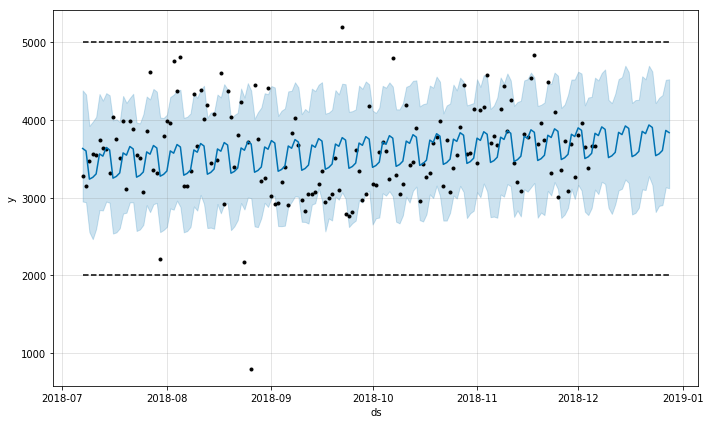

In [57]:
future = m.make_future_dataframe(periods=22)
future['cap'] = 5000
future['floor'] = 2000

forecast = m.predict(future)

fig1 = m.plot(forecast)


In [58]:
from fbprophet.diagnostics import cross_validation, performance_metrics
# cross_validation(m, initial = 730, period = 180, horizon = 365, units = 'days')
df_cv = cross_validation(m, horizon='30 days', period='14 days')


df_p = performance_metrics(df_cv)

df_p['rmse'].mean()


INFO:fbprophet:Making 3 forecasts with cutoffs between 2018-10-09 00:00:00 and 2018-11-06 00:00:00


426.9200046383844

In [59]:
d_df['y'].mean()

3597.372549019608

In [61]:
426/3597

0.11843202668890743

In [28]:
# need date range 2018-12-07 to 2018-12-28 225-246

In [29]:
# missing_pred = forecast.loc[225:246][['ds','yhat']]

In [30]:
# missing_pred.rename(columns={'yhat': 'calories_burned', 'ds': 'date'}, inplace=True)

In [31]:
# cal_df = df[['date', 'calories_burned']]

In [32]:
# full_df = cal_df.append(missing_pred)

In [33]:
# plt.figure(figsize=(16,6))
# sns.lineplot(full_df.date, full_df.calories_burned)

In [34]:
# df = df[72:]